# New Section

In [7]:
import os
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:


class SeamCarver:
    def __init__(self, filename, out_height, out_width, protect_mask='', object_mask=''):
        # initialize parameter
        self.filename = filename
        self.out_height = out_height
        self.out_width = out_width

        # read in image
        self.in_image = cv2.imread(filename).astype(np.float64)
        self.in_height, self.in_width = self.in_image.shape[: 2]

        # keep tracking resulting image
        self.out_image = np.copy(self.in_image)

        # object removal --> self.object = True
        self.object = (object_mask != '')
        if self.object:
            # read in object mask image file as np.float64 format in gray scale
            self.mask = cv2.imread(object_mask, 0).astype(np.float64)
            self.protect = False
        # image re-sizing with or without protect mask
        else:
            self.protect = (protect_mask != '')
            if self.protect:
                # if protect_mask filename is provided, read in protect mask image file in gray scale
                self.mask = cv2.imread(protect_mask, 0).astype(np.float64)

        # kernel for forward energy map calculation
        self.kernel_x = np.array([[0., 0., 0.], [-1., 0., 1.], [0., 0., 0.]], dtype=np.float64)
        self.kernel_y_left = np.array([[0., 0., 0.], [0., 0., 1.], [0., -1., 0.]], dtype=np.float64)
        self.kernel_y_right = np.array([[0., 0., 0.], [1., 0., 0.], [0., -1., 0.]], dtype=np.float64)

        # constant for covered area by protect mask or object mask
        self.constant = 1000

        # starting program
        self.start()




    def start(self):
        if self.object:
            self.object_removal()
        else:
            self.seams_carving()


    def seams_carving(self):
        """
        We first process seam insertion or removal in vertical direction then followed by horizontal direction.

        If targeting height or width is greater than original ones --> seam insertion,
        else --> seam removal

        The algorithm is written for seam processing in vertical direction (column), so image is rotated 90 degree
        counter-clockwise for seam processing in horizontal direction (row)
        """

        # calculate number of rows and columns needed to be inserted or removed
        delta_row, delta_col = int(self.out_height - self.in_height), int(self.out_width - self.in_width)

        # remove column
        if delta_col < 0:
            self.seams_removal(delta_col * -1)
        # insert column
        elif delta_col > 0:
            self.seams_insertion(delta_col)

        # remove row
        if delta_row < 0:
            self.out_image = self.rotate_image(self.out_image, 1)
            if self.protect:
                self.mask = self.rotate_mask(self.mask, 1)
            self.seams_removal(delta_row * -1)
            self.out_image = self.rotate_image(self.out_image, 0)
        # insert row
        elif delta_row > 0:
            self.out_image = self.rotate_image(self.out_image, 1)
            if self.protect:
                self.mask = self.rotate_mask(self.mask, 1)
            self.seams_insertion(delta_row)
            self.out_image = self.rotate_image(self.out_image, 0)


    def object_removal(self):
        rotate = False
        object_height, object_width = self.get_object_dimension()
        if object_height < object_width:
            self.out_image = self.rotate_image(self.out_image, 1)
            self.mask = self.rotate_mask(self.mask, 1)
            rotate = True

        while len(np.where(self.mask[:, :] > 0)[0]) > 0:
            energy_map = self.calc_energy_map()
            energy_map[np.where(self.mask[:, :] > 0)] *= -self.constant
            cumulative_map = self.cumulative_map_forward(energy_map)
            seam_idx = self.find_seam(cumulative_map)
            self.delete_seam(seam_idx)
            self.delete_seam_on_mask(seam_idx)

        if not rotate:
            num_pixels = self.in_width - self.out_image.shape[1]
        else:
            num_pixels = self.in_height - self.out_image.shape[1]

        self.seams_insertion(num_pixels)
        if rotate:
            self.out_image = self.rotate_image(self.out_image, 0)


    def seams_removal(self, num_pixel):
        if self.protect:
            for dummy in range(num_pixel):
                energy_map = self.calc_energy_map()
                energy_map[np.where(self.mask > 0)] *= self.constant
                cumulative_map = self.cumulative_map_forward(energy_map)
                seam_idx = self.find_seam(cumulative_map)
                self.delete_seam(seam_idx)
                self.delete_seam_on_mask(seam_idx)
        else:
            for dummy in range(num_pixel):
                energy_map = self.calc_energy_map()
                cumulative_map = self.cumulative_map_forward(energy_map)
                seam_idx = self.find_seam(cumulative_map)
                self.delete_seam(seam_idx)


    def seams_insertion(self, num_pixel):
        if self.protect:
            temp_image = np.copy(self.out_image)
            temp_mask = np.copy(self.mask)
            seams_record = []

            for dummy in range(num_pixel):
                energy_map = self.calc_energy_map()
                energy_map[np.where(self.mask[:, :] > 0)] *= self.constant
                cumulative_map = self.cumulative_map_backward(energy_map)
                seam_idx = self.find_seam(cumulative_map)
                seams_record.append(seam_idx)
                self.delete_seam(seam_idx)
                self.delete_seam_on_mask(seam_idx)

            self.out_image = np.copy(temp_image)
            self.mask = np.copy(temp_mask)
            n = len(seams_record)
            for dummy in range(n):
                seam = seams_record.pop(0)
                self.add_seam(seam)
                self.add_seam_on_mask(seam)
                seams_record = self.update_seams(seams_record, seam)
        else:
            temp_image = np.copy(self.out_image)
            seams_record = []

            for dummy in range(num_pixel):
                energy_map = self.calc_energy_map()
                cumulative_map = self.cumulative_map_backward(energy_map)
                seam_idx = self.find_seam(cumulative_map)
                seams_record.append(seam_idx)
                self.delete_seam(seam_idx)

            self.out_image = np.copy(temp_image)
            n = len(seams_record)
            for dummy in range(n):
                seam = seams_record.pop(0)
                self.add_seam(seam)
                seams_record = self.update_seams(seams_record, seam)


    def calc_energy_map(self):
        b, g, r = cv2.split(self.out_image)
        b_energy = np.absolute(cv2.Scharr(b, -1, 1, 0)) + np.absolute(cv2.Scharr(b, -1, 0, 1))
        g_energy = np.absolute(cv2.Scharr(g, -1, 1, 0)) + np.absolute(cv2.Scharr(g, -1, 0, 1))
        r_energy = np.absolute(cv2.Scharr(r, -1, 1, 0)) + np.absolute(cv2.Scharr(r, -1, 0, 1))
        return b_energy + g_energy + r_energy


    def cumulative_map_backward(self, energy_map):
        m, n = energy_map.shape
        output = np.copy(energy_map)
        for row in range(1, m):
            for col in range(n):
                output[row, col] = \
                    energy_map[row, col] + np.amin(output[row - 1, max(col - 1, 0): min(col + 2, n - 1)])
        return output


    def cumulative_map_forward(self, energy_map):
        matrix_x = self.calc_neighbor_matrix(self.kernel_x)
        matrix_y_left = self.calc_neighbor_matrix(self.kernel_y_left)
        matrix_y_right = self.calc_neighbor_matrix(self.kernel_y_right)

        m, n = energy_map.shape
        output = np.copy(energy_map)
        for row in range(1, m):
            for col in range(n):
                if col == 0:
                    e_right = output[row - 1, col + 1] + matrix_x[row - 1, col + 1] + matrix_y_right[row - 1, col + 1]
                    e_up = output[row - 1, col] + matrix_x[row - 1, col]
                    output[row, col] = energy_map[row, col] + min(e_right, e_up)
                elif col == n - 1:
                    e_left = output[row - 1, col - 1] + matrix_x[row - 1, col - 1] + matrix_y_left[row - 1, col - 1]
                    e_up = output[row - 1, col] + matrix_x[row - 1, col]
                    output[row, col] = energy_map[row, col] + min(e_left, e_up)
                else:
                    e_left = output[row - 1, col - 1] + matrix_x[row - 1, col - 1] + matrix_y_left[row - 1, col - 1]
                    e_right = output[row - 1, col + 1] + matrix_x[row - 1, col + 1] + matrix_y_right[row - 1, col + 1]
                    e_up = output[row - 1, col] + matrix_x[row - 1, col]
                    output[row, col] = energy_map[row, col] + min(e_left, e_right, e_up)
        return output


    def calc_neighbor_matrix(self, kernel):
        b, g, r = cv2.split(self.out_image)
        output = np.absolute(cv2.filter2D(b, -1, kernel=kernel)) + \
                 np.absolute(cv2.filter2D(g, -1, kernel=kernel)) + \
                 np.absolute(cv2.filter2D(r, -1, kernel=kernel))
        return output


    def find_seam(self, cumulative_map):
        m, n = cumulative_map.shape
        output = np.zeros((m,), dtype=np.uint32)
        output[-1] = np.argmin(cumulative_map[-1])
        for row in range(m - 2, -1, -1):
            prv_x = output[row + 1]
            if prv_x == 0:
                output[row] = np.argmin(cumulative_map[row, : 2])
            else:
                output[row] = np.argmin(cumulative_map[row, prv_x - 1: min(prv_x + 2, n - 1)]) + prv_x - 1
        return output


    def delete_seam(self, seam_idx):
        m, n = self.out_image.shape[: 2]
        output = np.zeros((m, n - 1, 3))
        for row in range(m):
            col = seam_idx[row]
            output[row, :, 0] = np.delete(self.out_image[row, :, 0], [col])
            output[row, :, 1] = np.delete(self.out_image[row, :, 1], [col])
            output[row, :, 2] = np.delete(self.out_image[row, :, 2], [col])
        self.out_image = np.copy(output)


    def add_seam(self, seam_idx):
        m, n = self.out_image.shape[: 2]
        output = np.zeros((m, n + 1, 3))
        for row in range(m):
            col = seam_idx[row]
            for ch in range(3):
                if col == 0:
                    p = np.average(self.out_image[row, col: col + 2, ch])
                    output[row, col, ch] = self.out_image[row, col, ch]
                    output[row, col + 1, ch] = p
                    output[row, col + 1:, ch] = self.out_image[row, col:, ch]
                else:
                    p = np.average(self.out_image[row, col - 1: col + 1, ch])
                    output[row, : col, ch] = self.out_image[row, : col, ch]
                    output[row, col, ch] = p
                    output[row, col + 1:, ch] = self.out_image[row, col:, ch]
        self.out_image = np.copy(output)


    def update_seams(self, remaining_seams, current_seam):
        output = []
        for seam in remaining_seams:
            seam[np.where(seam >= current_seam)] += 2
            output.append(seam)
        return output


    def rotate_image(self, image, ccw):
        m, n, ch = image.shape
        output = np.zeros((n, m, ch))
        if ccw:
            image_flip = np.fliplr(image)
            for c in range(ch):
                for row in range(m):
                    output[:, row, c] = image_flip[row, :, c]
        else:
            for c in range(ch):
                for row in range(m):
                    output[:, m - 1 - row, c] = image[row, :, c]
        return output


    def rotate_mask(self, mask, ccw):
        m, n = mask.shape
        output = np.zeros((n, m))
        if ccw > 0:
            image_flip = np.fliplr(mask)
            for row in range(m):
                output[:, row] = image_flip[row, : ]
        else:
            for row in range(m):
                output[:, m - 1 - row] = mask[row, : ]
        return output


    def delete_seam_on_mask(self, seam_idx):
        m, n = self.mask.shape
        output = np.zeros((m, n - 1))
        for row in range(m):
            col = seam_idx[row]
            output[row, : ] = np.delete(self.mask[row, : ], [col])
        self.mask = np.copy(output)


    def add_seam_on_mask(self, seam_idx):
        m, n = self.mask.shape
        output = np.zeros((m, n + 1))
        for row in range(m):
            col = seam_idx[row]
            if col == 0:
                p = np.average(self.mask[row, col: col + 2])
                output[row, col] = self.mask[row, col]
                output[row, col + 1] = p
                output[row, col + 1: ] = self.mask[row, col: ]
            else:
                p = np.average(self.mask[row, col - 1: col + 1])
                output[row, : col] = self.mask[row, : col]
                output[row, col] = p
                output[row, col + 1: ] = self.mask[row, col: ]
        self.mask = np.copy(output)


    def get_object_dimension(self):
        rows, cols = np.where(self.mask > 0)
        height = np.amax(rows) - np.amin(rows) + 1
        width = np.amax(cols) - np.amin(cols) + 1
        return height, width


    def save_result(self, filename):
        cv2.imwrite(filename, self.out_image.astype(np.uint8))





def image_resize_without_mask(filename_input, filename_output, new_height, new_width):
    obj = SeamCarver(filename_input, new_height, new_width)
    obj.save_result(filename_output)


def image_resize_with_mask(filename_input, filename_output, new_height, new_width, filename_mask):
    obj = SeamCarver(filename_input, new_height, new_width, protect_mask=filename_mask)
    obj.save_result(filename_output)


def object_removal(filename_input, filename_output, filename_mask):
    obj = SeamCarver(filename_input, 0, 0, object_mask=filename_mask)
    obj.save_result(filename_output)








# Scale adjustment
new_height = 500
new_width = 450

input_image = '/content/drive/My Drive/seam1.jpg'
input_mask = '/content/drive/My Drive/seam1_mask.jpg'
output_image = '/content/drive/My Drive/seam1_result.jpg'


# Select only one function!

#image_resize_without_mask(input_image, output_image, new_height, new_width)
#image_resize_with_mask(input_image, output_image, new_height, new_width, input_mask)
#object_removal(input_image, output_image, input_mask)










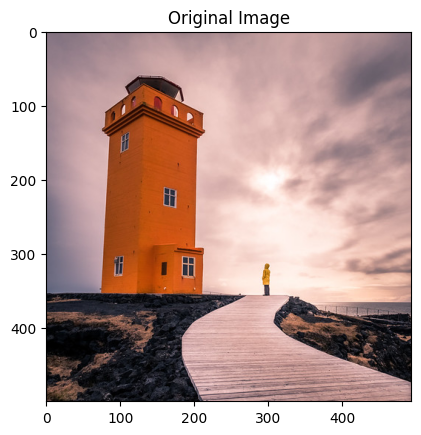

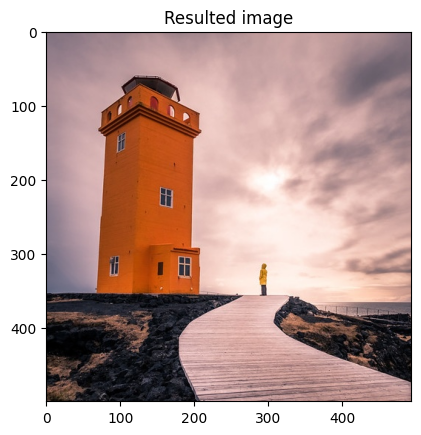

In [4]:
img = mpimg.imread('/content/drive/My Drive/seam1.jpg')
imgplot = plt.imshow(img)
plt.title('Original Image')
plt.show()
result = mpimg.imread('/content/drive/My Drive/seam1_result.jpg')
imgplot = plt.imshow(result)
plt.title('Resulted image')
plt.show()